Members: 
- Christopher Lim 
- Nathan Von Rodriguez  

Section: S11  
Data Source: [https://www.kaggle.com/datasets/puneet6060/intel-image-classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)  
References:
- https://iq.opengenus.org/basics-of-machine-learning-image-classification-techniques/
- https://www.kaggle.com/code/artem8verbov/pytorch-cnn

In [1]:
import os
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Fix the seed of the random number 
# generator so that your results will match ours
np.random.seed(1)

%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Mon Jun 20 13:15:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P5    17W /  N/A |    253MiB /  8192MiB |     49%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## [Skip to import data when pickle files are available] Convert all the images and labels into a single pickle file 
The original data from kaggle only contained a directory of images. The images were the features (height, width, rgb) then the labels were the folder name that the image was in (ex. building, forest, etc.).  
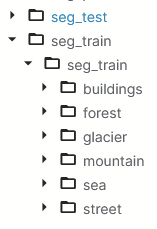  

Since there were so many image files, it was not possible to upload all these to github for collaboration.  

To solve this, all the images have to be in a single file and use Git LFS to upload the data.

### Extract data from directory

In [3]:
train_data = {
    'filename': [],
    'label': []
}
test_data = {
    'filename': [],
    'label': []
}
for root, _, files in os.walk('./data_orig/seg_train'):
    if(len(files) > 0):
        label = root.split('\\')[1].title()
        print('Train (%s): %d' % (label, len(files)))
    for file in files:
        if(re.search(r'\d.jpg', file)):
            filename = '%s/%s' % (root, file)
            train_data['filename'].append(filename)
            train_data['label'].append(label)
print('Train Images: %d\n' % len(train_data['filename']))
        
for root, _, files in os.walk('./data_orig/seg_test'):
    if(len(files) > 0):
        label = root.split('\\')[1].title()
        print('Test (%s): %d' % (label, len(files)))
    for file in files:
        if(re.search(r'\d.jpg', file)):
            filename = '%s/%s' % (root, file)
            test_data['filename'].append(filename)
            test_data['label'].append(label)
print('Test Images: %d' % len(test_data['filename']))

Train (Buildings): 2191
Train (Forest): 2271
Train (Glacier): 2404
Train (Mountain): 2512
Train (Sea): 2274
Train (Street): 2382
Train Images: 14034

Test (Buildings): 437
Test (Forest): 474
Test (Glacier): 553
Test (Mountain): 525
Test (Sea): 510
Test (Street): 501
Test Images: 3000


### Open each image then resize everything to 150x150
If an image is already 150x150 then there would be no changes. However if an image is not 150x150, the image will be either shrinked or stretched to have a consistent 150x150 pixel width and height.

In [4]:
datas = {
    'features': [],
    'labels': [],
}

count = 0
for file, label in zip(train_data['filename'], train_data['label']):
    img = Image.open(file).resize((150, 150), Image.ANTIALIAS)
    datas['features'].append(np.array(img))
    datas['labels'].append(label)
print('Train Images:', len(train_data['filename']))

for file, label in zip(test_data['filename'], test_data['label']):
    img = Image.open(file).resize((150, 150), Image.ANTIALIAS)
    datas['features'].append(np.array(img))
    datas['labels'].append(label)
print('Test Images:', len(test_data['filename']))

del file
del label
del img

Train Images: 14034
Test Images: 3000


### Export images (in the dict) to a pickle file
Export images into .pickle files. To limit the file size, each .pickle file will contain 500 data points.

In [9]:
data_points_per_file = 250
for i in range(int(len(datas['features']) / data_points_per_file) + 1):
    start = i * data_points_per_file
    end = min((i + 1) * data_points_per_file, len(datas['features']))
    temp_data = {
        'features': datas['features'][start: end],
        'labels': datas['labels'][start: end],
    }
    with open('./data/images_%d.pickle' % (i + 1), 'wb') as f:
        pickle.dump(temp_data, f)
    print(start, '-', end, '-> exported')
print(i)

del i
del start
del end
del temp_data

0 - 250 -> exported
250 - 500 -> exported
500 - 750 -> exported
750 - 1000 -> exported
1000 - 1250 -> exported
1250 - 1500 -> exported
1500 - 1750 -> exported
1750 - 2000 -> exported
2000 - 2250 -> exported
2250 - 2500 -> exported
2500 - 2750 -> exported
2750 - 3000 -> exported
3000 - 3250 -> exported
3250 - 3500 -> exported
3500 - 3750 -> exported
3750 - 4000 -> exported
4000 - 4250 -> exported
4250 - 4500 -> exported
4500 - 4750 -> exported
4750 - 5000 -> exported
5000 - 5250 -> exported
5250 - 5500 -> exported
5500 - 5750 -> exported
5750 - 6000 -> exported
6000 - 6250 -> exported
6250 - 6500 -> exported
6500 - 6750 -> exported
6750 - 7000 -> exported
7000 - 7250 -> exported
7250 - 7500 -> exported
7500 - 7750 -> exported
7750 - 8000 -> exported
8000 - 8250 -> exported
8250 - 8500 -> exported
8500 - 8750 -> exported
8750 - 9000 -> exported
9000 - 9250 -> exported
9250 - 9500 -> exported
9500 - 9750 -> exported
9750 - 10000 -> exported
10000 - 10250 -> exported
10250 - 10500 -> expor

## Import data

### Import Data from pickle file

In [10]:
X = []
y = []

for root, _, files in os.walk('./data'):
    for file in files:
        # only open if pickle file
        if('.pickle' in file):
            with open('./data/%s' % file, 'rb') as f:
                images = pickle.load(f)
                if(len(X) > 0):
                    X = np.concatenate([X, images['features']])
                    y = np.concatenate([y, images['labels']])
                else:
                    X = np.array(images['features'])
                    y = np.array(images['labels'])
                print(file, '-> imported')

total_images = len(X)
print('Total Images:', total_images)

del root
del files
del images

images_1.pickle -> imported
images_2.pickle -> imported
images_3.pickle -> imported
images_4.pickle -> imported
images_5.pickle -> imported
images_6.pickle -> imported
images_7.pickle -> imported
images_8.pickle -> imported
images_9.pickle -> imported
images_10.pickle -> imported
images_11.pickle -> imported
images_12.pickle -> imported
images_13.pickle -> imported
images_14.pickle -> imported
images_15.pickle -> imported
images_16.pickle -> imported
images_17.pickle -> imported
images_18.pickle -> imported
images_19.pickle -> imported
images_20.pickle -> imported
images_21.pickle -> imported
images_22.pickle -> imported
images_23.pickle -> imported
images_24.pickle -> imported
images_25.pickle -> imported
images_26.pickle -> imported
images_27.pickle -> imported
images_28.pickle -> imported
images_29.pickle -> imported
images_30.pickle -> imported
images_31.pickle -> imported
images_32.pickle -> imported
images_33.pickle -> imported
images_34.pickle -> imported
images_35.pickle -> imp

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print('Train Images:', len(X_train))
print('Test Images:', len(X_test))

Train Images: 13627
Test Images: 3407


Convert lists into numpy array

In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (13627, 150, 150, 3)
Training labels shape:  (13627,)
Test data shape:  (3407, 150, 150, 3)
Test labels shape:  (3407,)


### Visualizing the Dataset

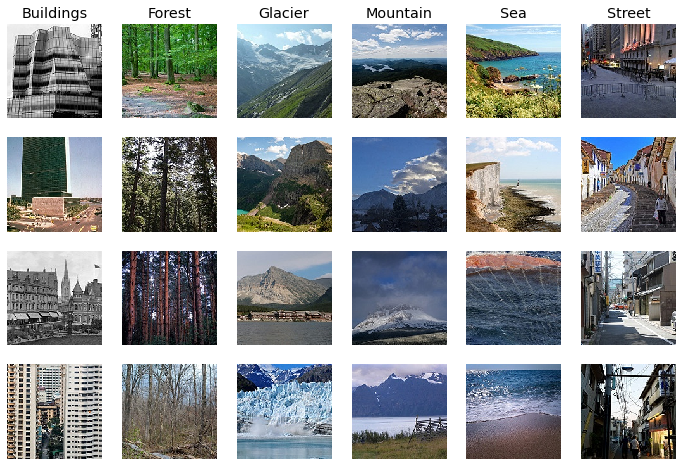

In [9]:
classes = ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street']

num_classes = len(classes)
samples_per_class = 4

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False) 
    for i, idx in enumerate(idxs):
        # show items in column (per class)
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

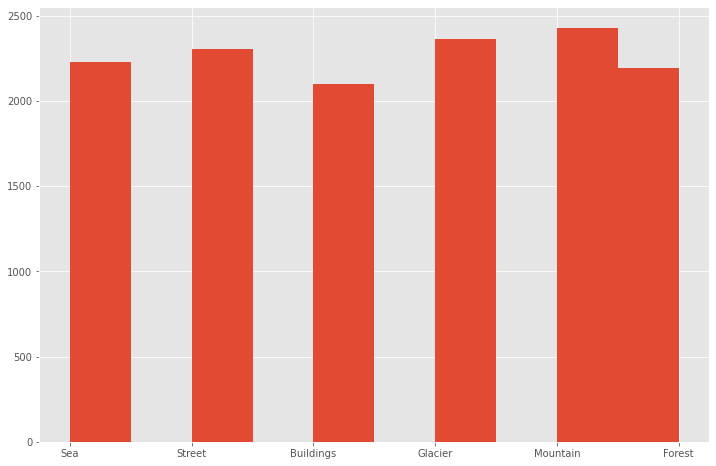

In [10]:
_ = plt.hist(y_train)

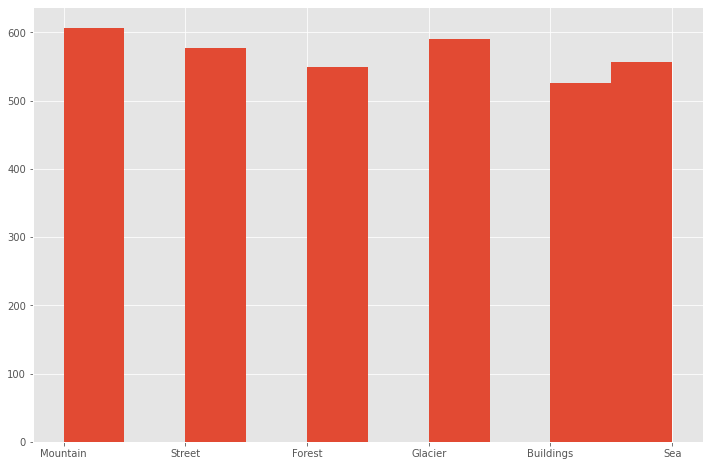

In [11]:
_ = plt.hist(y_test)

## Data processing

### Convert 3D array which represents the image into a 1D array

In [12]:
X_train = X_train.reshape([len(X_train), 67500])
X_test = X_test.reshape([len(X_test), 67500])
print(X_train.shape)
print(X_test.shape)

(13627, 67500)
(3407, 67500)


### Convert the string labels into int index

In [13]:
y_train = np.array([classes.index(y) for y in y_train])
y_test = np.array([classes.index(y) for y in y_test])
print(y_train)
print(y_test)

[4 5 0 ... 5 2 5]
[3 5 1 ... 1 4 0]


### Mask Train Datas for faster training (only used of experimentation of models)

In [14]:
train_idxs = np.random.choice(range(len(X_train)), 1000, replace=False)
test_idxs = np.random.choice(range(len(X_test)), 300, replace=False)
print(len(train_idxs), len(test_idxs))

1000 300


In [15]:
X_train_mask = X_train[train_idxs]
y_train_mask = y_train[train_idxs]
print(X_train_mask.shape)
print(y_train_mask.shape)
X_test_mask = X_test[test_idxs]
y_test_mask = y_test[test_idxs]
print(X_test_mask.shape)
print(y_test_mask.shape)

(1000, 67500)
(1000,)
(300, 67500)
(300,)


(array([158.,   0., 140.,   0., 189.,   0., 203.,   0., 152., 158.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

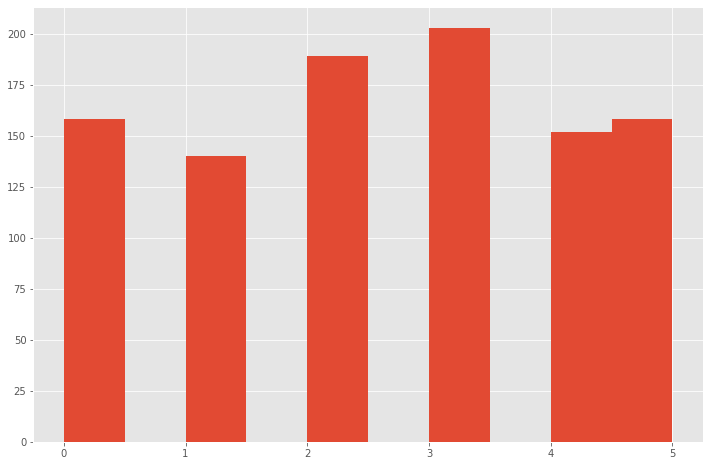

In [16]:
plt.hist(y_train_mask)

(array([39.,  0., 52.,  0., 52.,  0., 50.,  0., 52., 55.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

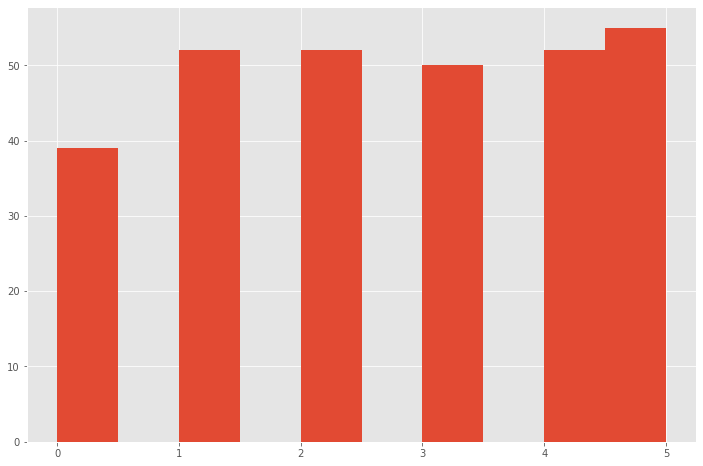

In [17]:
plt.hist(y_test_mask)

## Develop Image Classification Model

### K Nearest Neighbors
#### Apply K Fold and determine the best K value.

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

k_folds = 5

hyperparameters = [
    {
        'n_neighbors': [100, 200, 250, 300, 400, 500, 1000],
    }
]

knn = KNeighborsClassifier()

In [49]:
rs_knn = RandomizedSearchCV(knn, hyperparameters, n_iter=50, cv=k_folds)

rs_knn.fit(X_train_mask, y_train_mask)

ValueError: Invalid parameter min_samples_split for estimator KNeighborsClassifier(). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
rs_knn.best_params_

#### Training with the best K value

In [42]:
best_k = 250
model = KNeighborsClassifier(n_neighbors=best_k)

model.fit(X_train_mask, y_train_mask)

knn_y_pred = model.predict(X_test_mask)

#### Evaluating Performance

In [43]:
from sklearn.metrics import classification_report

In [45]:
print(classification_report(y_test_mask, knn_y_pred, target_names=classes))

              precision    recall  f1-score   support

   Buildings       0.00      0.00      0.00        41
      Forest       0.49      0.76      0.60        45
     Glacier       0.45      0.63      0.53        63
    Mountain       0.40      0.78      0.53        55
         Sea       0.23      0.15      0.18        53
      Street       0.00      0.00      0.00        43

    accuracy                           0.42       300
   macro avg       0.26      0.39      0.31       300
weighted avg       0.28      0.42      0.33       300



c:\users\chris\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chris\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\chris\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Support Vector Machine

In [46]:
from sklearn.svm import SVC

model = SVC()

model.fit(X_train_mask, y_train_mask)

svm_y_pred = model.predict(X_test_mask)

#### Evaluating Performance

In [47]:
print(classification_report(y_test_mask, svm_y_pred, target_names=classes))

              precision    recall  f1-score   support

   Buildings       0.43      0.49      0.46        41
      Forest       0.64      0.64      0.64        45
     Glacier       0.55      0.67      0.60        63
    Mountain       0.58      0.55      0.56        55
         Sea       0.46      0.23      0.30        53
      Street       0.47      0.60      0.53        43

    accuracy                           0.53       300
   macro avg       0.52      0.53      0.52       300
weighted avg       0.53      0.53      0.52       300



### CNN

#### Evaluating Performance

## Results and Analysis

### Performance Evaluation
TODO:
1. Create a table of something like 
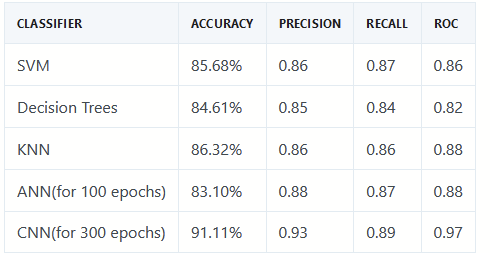
2. 

### Best Model